Epoch 0/30
train Loss: 0.4703 Acc: 0.8505 Recall: 0.8478
val Loss: 0.2188 Acc: 0.9329 Recall: 0.9300

Epoch 1/30
train Loss: 0.3074 Acc: 0.9082 Recall: 0.9061
val Loss: 0.1899 Acc: 0.9484 Recall: 0.9464

Epoch 2/30
train Loss: 0.3111 Acc: 0.9208 Recall: 0.9192
val Loss: 0.2766 Acc: 0.9366 Recall: 0.9395

Epoch 3/30
train Loss: 0.3629 Acc: 0.9248 Recall: 0.9229
val Loss: 0.2856 Acc: 0.9459 Recall: 0.9436

Epoch 4/30
train Loss: 0.3711 Acc: 0.9257 Recall: 0.9242
val Loss: 0.3230 Acc: 0.9354 Recall: 0.9339

Epoch 5/30
train Loss: 0.3535 Acc: 0.9300 Recall: 0.9284
val Loss: 0.3287 Acc: 0.9377 Recall: 0.9385

Epoch 6/30
train Loss: 0.3432 Acc: 0.9326 Recall: 0.9309
val Loss: 0.3324 Acc: 0.9325 Recall: 0.9318

Epoch 7/30
train Loss: 0.3374 Acc: 0.9361 Recall: 0.9349
val Loss: 0.3574 Acc: 0.9303 Recall: 0.9293

Epoch 8/30
train Loss: 0.3408 Acc: 0.9347 Recall: 0.9331
val Loss: 0.3665 Acc: 0.9280 Recall: 0.9252

Epoch 9/30
train Loss: 0.3291 Acc: 0.9360 Recall: 0.9343
val Loss: 0.3492 Acc: 0.9

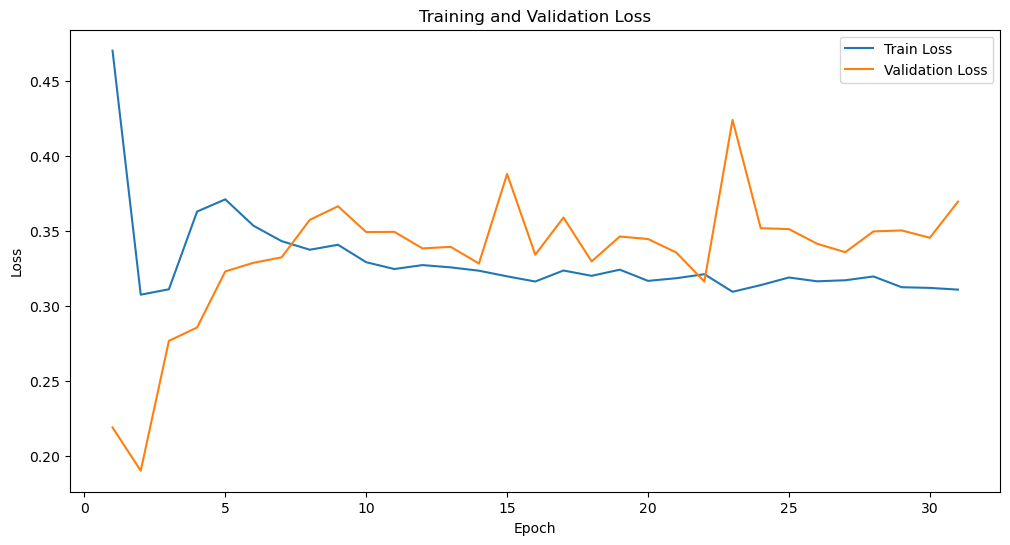

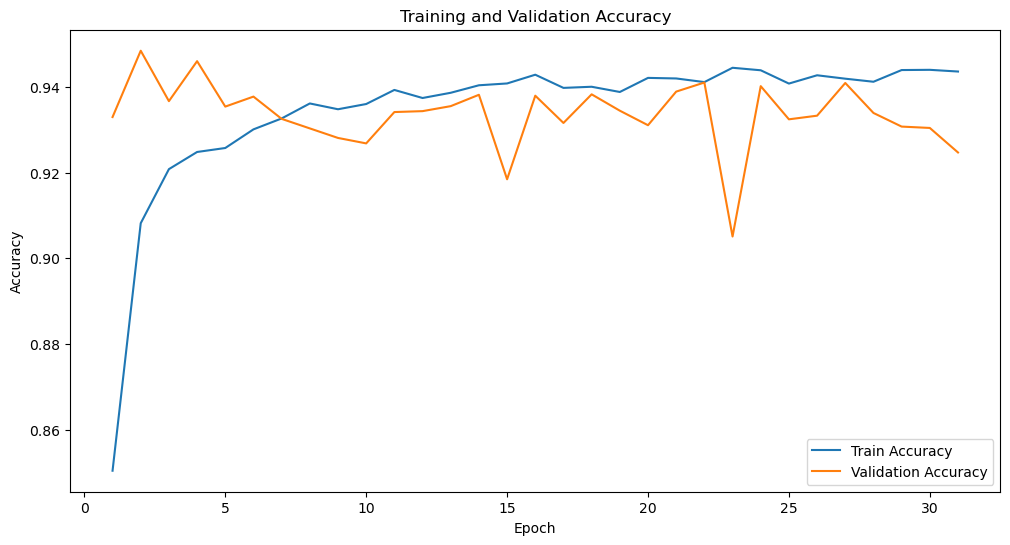

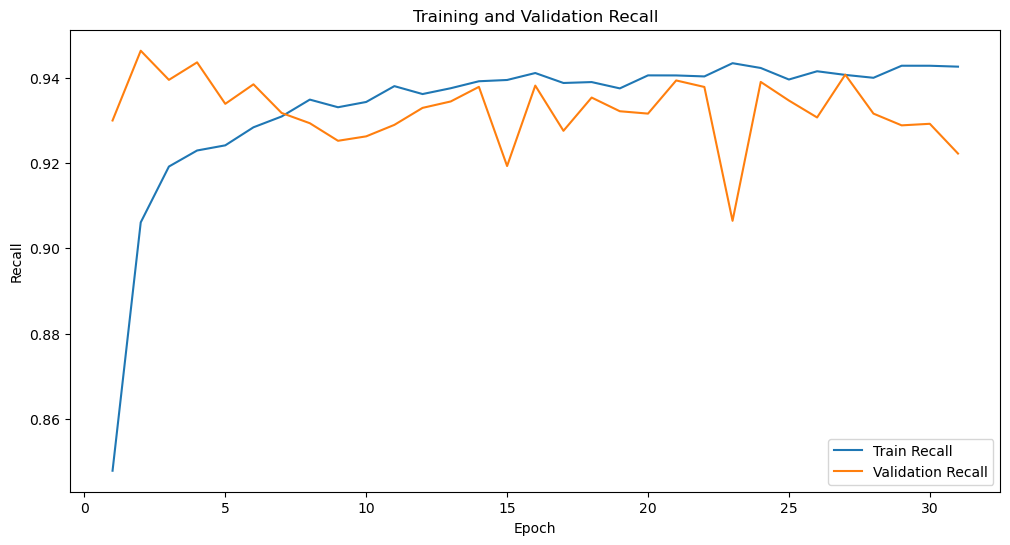

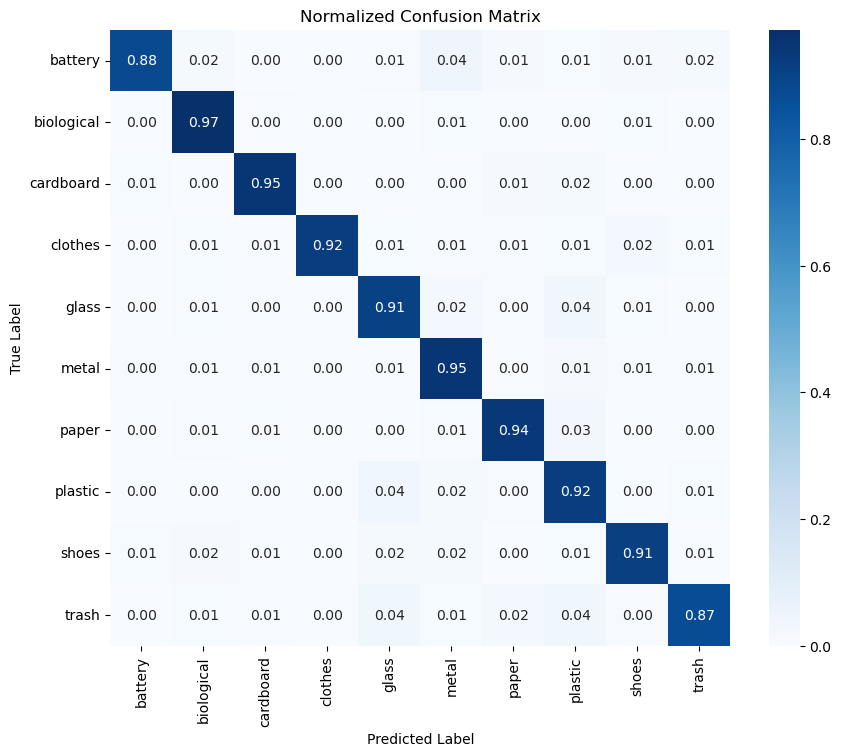

In [3]:
import os
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score, confusion_matrix
import seaborn as sns
import numpy as np
# 데이터 전처리
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
data_dir = './final'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=16, shuffle=True, num_workers=4)
               for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# MobileNet 모델 불러오기 및 수정
model = models.mobilenet_v2(pretrained=True)
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, len(class_names))
model = model.to(device)
# 학습 및 평가 함수
def train_model(model, criterion, optimizer, start_epoch=0, num_epochs=10):
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []
    train_recall_history = []
    val_recall_history = []
    for epoch in range(start_epoch, start_epoch + num_epochs):
        epoch_str = f'Epoch {epoch}/{start_epoch + num_epochs - 1}'
        print(epoch_str)
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            running_loss = 0.0
            running_corrects = 0
            all_preds = []
            all_labels = []
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                # GPU 메모리 정리
                del inputs, labels, outputs, preds
                torch.cuda.empty_cache()
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            epoch_recall = recall_score(all_labels, all_preds, average='macro')
            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc.item())
                train_recall_history.append(epoch_recall)
            else:
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc.item())
                val_recall_history.append(epoch_recall)
            log_str = f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} Recall: {epoch_recall:.4f}'
            print(log_str)
        print()
    return model, train_loss_history, val_loss_history, train_acc_history, val_acc_history, train_recall_history, val_recall_history
# 최적의 하이퍼파라미터 설정
best_params = {
    'learning_rate': 0.0002091067002623071,
    'weight_decay': 0.0042590114903666605,
    'dropout': 0.4
}
# 모델 학습
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=best_params['learning_rate'], weight_decay=best_params['weight_decay'])
model.classifier = nn.Sequential(
    nn.Dropout(best_params['dropout']),
    nn.Linear(num_ftrs, len(class_names))
)
model = model.to(device)
# 모델 학습
model, train_loss_history, val_loss_history, train_acc_history, val_acc_history, train_recall_history, val_recall_history = train_model(model, criterion, optimizer, start_epoch=0, num_epochs=31)
# 모델 저장
torch.save(model.state_dict(), 'best_mobilenet_model.pth')
# 시각화
epochs = list(range(1, len(train_loss_history) + 1))
# 학습 및 검증 손실 시각화
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_loss_history, label='Train Loss')
plt.plot(epochs, val_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()
# 학습 및 검증 정확도 시각화
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_acc_history, label='Train Accuracy')
plt.plot(epochs, val_acc_history, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()
# 학습 및 검증 리콜 시각화
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_recall_history, label='Train Recall')
plt.plot(epochs, val_recall_history, label='Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()
plt.title('Training and Validation Recall')
plt.show()
# 모델 평가 및 혼동 행렬 계산 함수
def evaluate_model_and_plot_confusion_matrix(model, dataloader, class_names):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    # 혼동 행렬 계산
    cm = confusion_matrix(all_labels, all_preds)
    # 비율로 변환
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    # 혼동 행렬 시각화
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Normalized Confusion Matrix')
    plt.show()
# 검증 데이터셋에 대해 혼동 행렬 계산 및 시각화
evaluate_model_and_plot_confusion_matrix(model, dataloaders['val'], class_names)

In [1]:
# 각 에포크의 값을 리스트에 저장
train_losses = [0.4703, 0.3074, 0.3111, 0.3629, 0.3711, 0.3535, 0.3432, 0.3374, 0.3408, 0.3291,
                0.3246, 0.3272, 0.3257, 0.3235, 0.3197, 0.3162, 0.3236, 0.3200, 0.3241, 0.3167,
                0.3184, 0.3211, 0.3094, 0.3138, 0.3189, 0.3164, 0.3171, 0.3196, 0.3124, 0.3120, 0.3108]
train_accuracies = [0.8505, 0.9082, 0.9208, 0.9248, 0.9257, 0.9300, 0.9326, 0.9361, 0.9347, 0.9360,
                    0.9392, 0.9374, 0.9386, 0.9403, 0.9407, 0.9428, 0.9397, 0.9400, 0.9388, 0.9420,
                    0.9419, 0.9411, 0.9444, 0.9438, 0.9407, 0.9426, 0.9419, 0.9411, 0.9439, 0.9439, 0.9435]
train_recalls = [0.8478, 0.9061, 0.9192, 0.9229, 0.9242, 0.9284, 0.9309, 0.9349, 0.9331, 0.9343,
                 0.9381, 0.9362, 0.9376, 0.9392, 0.9395, 0.9411, 0.9388, 0.9390, 0.9375, 0.9406,
                 0.9406, 0.9403, 0.9434, 0.9423, 0.9396, 0.9415, 0.9407, 0.9400, 0.9428, 0.9428, 0.9426]

val_losses = [0.2188, 0.1899, 0.2766, 0.2856, 0.3230, 0.3287, 0.3324, 0.3574, 0.3665, 0.3492,
              0.3494, 0.3383, 0.3394, 0.3282, 0.3880, 0.3342, 0.3589, 0.3297, 0.3463, 0.3446,
              0.3357, 0.3162, 0.4241, 0.3518, 0.3512, 0.3415, 0.3358, 0.3497, 0.3503, 0.3454, 0.3695]
val_accuracies = [0.9329, 0.9484, 0.9366, 0.9459, 0.9354, 0.9377, 0.9325, 0.9303, 0.9280, 0.9268,
                  0.9341, 0.9343, 0.9355, 0.9381, 0.9184, 0.9379, 0.9315, 0.9382, 0.9344, 0.9310,
                  0.9388, 0.9410, 0.9051, 0.9401, 0.9324, 0.9332, 0.9409, 0.9339, 0.9307, 0.9304, 0.9247]
val_recalls = [0.9300, 0.9464, 0.9395, 0.9436, 0.9339, 0.9385, 0.9318, 0.9293, 0.9252, 0.9263,
               0.9290, 0.9329, 0.9345, 0.9379, 0.9193, 0.9382, 0.9276, 0.9354, 0.9322, 0.9316,
               0.9394, 0.9379, 0.9064, 0.9390, 0.9347, 0.9307, 0.9407, 0.9316, 0.9288, 0.9292, 0.9222]

# 평균 계산
avg_train_loss = sum(train_losses) / len(train_losses)
avg_train_acc = sum(train_accuracies) / len(train_accuracies)
avg_train_recall = sum(train_recalls) / len(train_recalls)

avg_val_loss = sum(val_losses) / len(val_losses)
avg_val_acc = sum(val_accuracies) / len(val_accuracies)
avg_val_recall = sum(val_recalls) / len(val_recalls)

print(f'Average Train Loss: {avg_train_loss:.4f}')
print(f'Average Train Accuracy: {avg_train_acc:.4f}')
print(f'Average Train Recall: {avg_train_recall:.4f}')
print(f'Average Validation Loss: {avg_val_loss:.4f}')
print(f'Average Validation Accuracy: {avg_val_acc:.4f}')
print(f'Average Validation Recall: {avg_val_recall:.4f}')


Average Train Loss: 0.3296
Average Train Accuracy: 0.9344
Average Train Recall: 0.9331
Average Validation Loss: 0.3341
Average Validation Accuracy: 0.9335
Average Validation Recall: 0.9324
